<a href="https://colab.research.google.com/github/Henriquerezer/Dissertacao/blob/main/Modelo_de_Regress%C3%A3o_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resumo do Código:
 Este código Python calcula métricas de avaliação (RMSE, R², MAE, ME e MAPE)
 para um modelo de regressão GB em um conjunto de dados. Ele inclui
 a divisão dos dados em conjuntos de treinamento e teste, pré-processamento dos
 dados, treinamento do modelo, validação cruzada e avaliação das previsões.


In [1]:
import matplotlib.pyplot as plt

def clarke_error_grid(ref_values, pred_values, title_string):

    assert len(ref_values) == len(pred_values), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    if max(ref_values) > 400 or max(pred_values) > 400:
        print("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    plt.clf()
    plt.figure(figsize=(7, 7))

    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string)
    plt.xlabel("Valores Referência (mg/dL)")
    plt.ylabel("Valores Preditos (mg/dL)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    plt.plot([0,400], [0,400], ':', c='black')
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return plt, zone

In [2]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error


In [3]:
# Carregue um arquivo Excel de dados em um DataFrame chamado 'data'.
data = pd.read_excel('/content/Treino (2).xlsx')

# Limpe os valores na coluna 'TEMP', removendo qualquer caractere "?".
data['TEMP'] = data['TEMP'].str.replace("?", "")

# Limpe os valores na coluna 'HUMIDADE', removendo o caractere "%" (símbolo de porcentagem).
data['HUMIDADE'] = data['HUMIDADE'].str.replace("%", "")

# Remova linhas com valores ausentes (NaN) do DataFrame 'data'.
data = data.dropna()

# Converta os valores na coluna 'TEMP' para o tipo de dado float (números decimais).
data['TEMP'] = data['TEMP'].astype(float)

# Converta os valores na coluna 'HUMIDADE' para o tipo de dado float (números decimais).
data['HUMIDADE'] = data['HUMIDADE'].astype(float)

# O DataFrame 'data' agora contém dados limpos e prontos para análise.


<ipython-input-3-b8415ba7d751>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['TEMP'] = data['TEMP'].str.replace("?", "")


In [4]:
# Função para calcular o MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

X = data.drop('mg/dL', axis=1)
y = data['mg/dL']

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


model = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 3, n_estimators = 300, random_state=42)

# Definir o número de folds para a validação cruzada
num_folds = 10

# Realizar a validação cruzada
scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error')

# Treinar o modelo com todos os dados de treinamento
model.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
y_pred = y_pred.astype(int)
# Calcular o RMSE e R² nos dados de teste
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE nos dados de teste: {rmse}")
print(f"R² nos dados de teste: {r2}")
print('MAPE', mape)
print('MAE', mae)

RMSE nos dados de teste: 50.297614257537106
R² nos dados de teste: 0.7387290531929616
MAPE 36.12245374128699
MAE 38.68333333333333


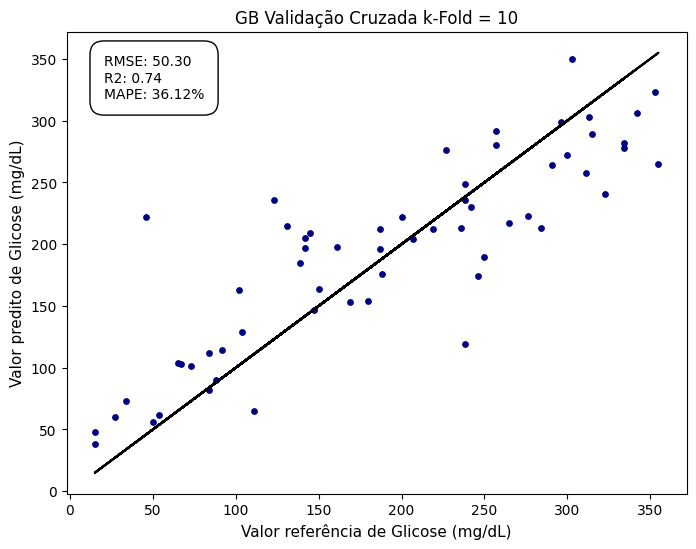

In [5]:
plt.figure(figsize=(8, 6))  # Define uma figura com largura 8 e altura 6
# Criar os pontos x para a linha reta
x_line = y_test

# Criar os pontos y para a linha reta
y_line = y_test

plt.plot(x_line, y_line, color='black', label='Linha Reta')
plt.scatter(y_test, y_pred, color='navy', label='Pontos Preditos', s= 15)

# Configurar os rótulos dos eixos
plt.xlabel('Valor referência de Glicose (mg/dL)', fontsize=11)
plt.ylabel('Valor predito de Glicose (mg/dL)', fontsize=11)

# Configurar o título do gráfico
plt.title('GB Validação Cruzada k-Fold = 10')

# Adicionar os valores de RMSE, R2 e MAPE no canto superior esquerdo
rmse_text = f'RMSE: {rmse:.2f}'
r2_text = f'R2: {r2:.2f}'
mape_text = f'MAPE: {mape:.2f}%'
plt.text(0.06, 0.95, f'{rmse_text}\n{r2_text}\n{mape_text}', transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# Exibir o gráfico
plt.savefig('GB validação.png')
plt.show()



# TESTE

In [6]:
# Carregue um arquivo Excel de dados em um DataFrame chamado 'data'.
data = pd.read_excel('/content/teste (2).xlsx')

# Limpe os valores na coluna 'TEMP', removendo qualquer caractere "?".
data['TEMP'] = data['TEMP'].str.replace("?", "")

# Limpe os valores na coluna 'HUMIDADE', removendo o caractere "%" (símbolo de porcentagem).
data['HUMIDADE'] = data['HUMIDADE'].str.replace("%", "")

# Remova linhas com valores ausentes (NaN) do DataFrame 'data'.
data = data.dropna()

# Converta os valores na coluna 'TEMP' para o tipo de dado float (números decimais).
data['TEMP'] = data['TEMP'].astype(float)

# Converta os valores na coluna 'HUMIDADE' para o tipo de dado float (números decimais).
data['HUMIDADE'] = data['HUMIDADE'].astype(float)

# O DataFrame 'data' agora contém dados limpos e prontos para análise.


<ipython-input-6-66431054d883>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['TEMP'] = data['TEMP'].str.replace("?", "")


RMSE 53.67786451875917
R² 0.7097706359129813
MAPE 48.74444600000736
MAE 46.25271507431303


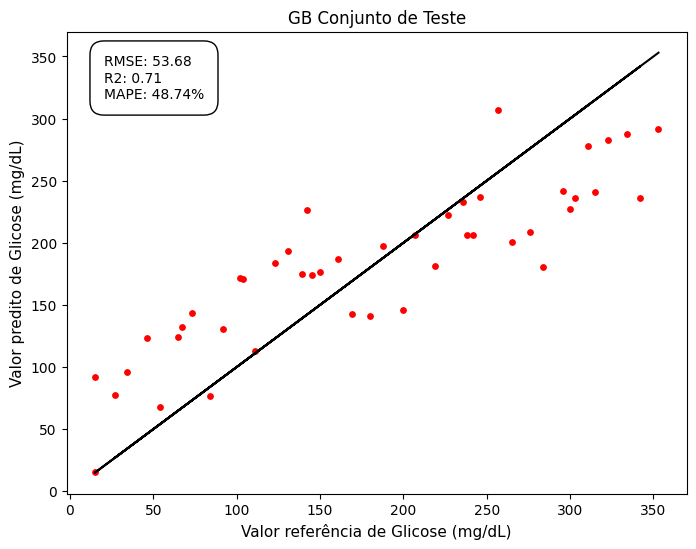

In [7]:
X = data.drop('mg/dL', axis=1)
y = data['mg/dL']

#X_test_scaled = scaler.transform(X)

y_pred = model.predict(X)

# Calcular as métricas de erro
rmse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print('RMSE', rmse)
print('R²', r2)
print('MAPE', mape)
print('MAE', mae)

plt.figure(figsize=(8, 6))  # Define uma figura com largura 8 e altura 6
# Criar os pontos x para a linha reta
x_line = y

# Criar os pontos y para a linha reta
y_line = y

plt.plot(x_line, y_line, color='black', label='Linha Reta')
plt.scatter(y, y_pred, color='red', label='Pontos Preditos', s= 15)

# Configurar os rótulos dos eixos
plt.xlabel('Valor referência de Glicose (mg/dL)', fontsize=11)
plt.ylabel('Valor predito de Glicose (mg/dL)', fontsize=11)

# Configurar o título do gráfico
plt.title('GB Conjunto de Teste')

# Adicionar os valores de RMSE, R2 e MAPE no canto superior esquerdo
rmse_text = f'RMSE: {rmse:.2f}'
r2_text = f'R2: {r2:.2f}'
mape_text = f'MAPE: {mape:.2f}%'
plt.text(0.06, 0.95, f'{rmse_text}\n{r2_text}\n{mape_text}', transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.savefig('GB teste.png')
# Exibir o gráfico
plt.show()


<Figure size 640x480 with 0 Axes>

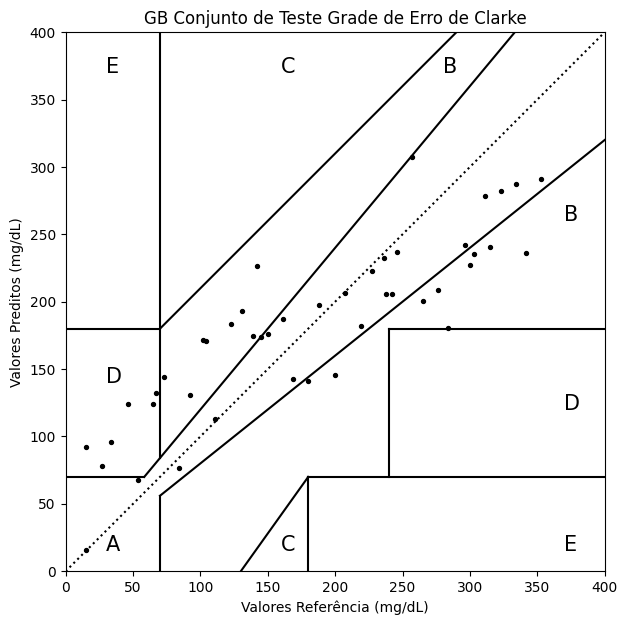

Pontos na Zona A: 22
Pontos na Zona B: 17
Pontos na Zona C: 0
Pontos na Zona D: 6
Pontos na Zona E: 0


In [8]:
# Dados de exemplo: valores de referência e medições do dispositivo
ref_values = data['mg/dL'].values
pred_values = y_pred

title_string = "GB Conjunto de Teste Grade de Erro de Clarke"

# Chamando a função clarke_error_grid
plot, zone = clarke_error_grid(data['mg/dL'].values, y_pred, title_string)

# Definindo o tamanho da figura

plt.savefig('GB TESTE CLARKE')
# Exibindo o gráfico
plot.show()

print("Pontos na Zona A:", zone[0])
print("Pontos na Zona B:", zone[1])
print("Pontos na Zona C:", zone[2])
print("Pontos na Zona D:", zone[3])
print("Pontos na Zona E:", zone[4])

# NOVAS LEITURAS

In [9]:
# Carregue um arquivo Excel de dados em um DataFrame chamado 'data'.
data = pd.read_excel('/content/teste_final.xlsx')

# Limpe os valores na coluna 'TEMP', removendo qualquer caractere "?".
data['TEMP'] = data['TEMP'].str.replace("?", "")

# Limpe os valores na coluna 'HUMIDADE', removendo o caractere "%" (símbolo de porcentagem).
data['HUMIDADE'] = data['HUMIDADE'].str.replace("%", "")

# Remova linhas com valores ausentes (NaN) do DataFrame 'data'.
data = data.dropna()

# Converta os valores na coluna 'TEMP' para o tipo de dado float (números decimais).
data['TEMP'] = data['TEMP'].astype(float)

# Converta os valores na coluna 'HUMIDADE' para o tipo de dado float (números decimais).
data['HUMIDADE'] = data['HUMIDADE'].astype(float)

# O DataFrame 'data' agora contém dados limpos e prontos para análise.


<ipython-input-9-8dc8bbe7be35>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['TEMP'] = data['TEMP'].str.replace("?", "")


RMSE 35.427286078703666
R² 0.8354262107965
MAPE 21.381906386698567
MAE 24.433241755875816


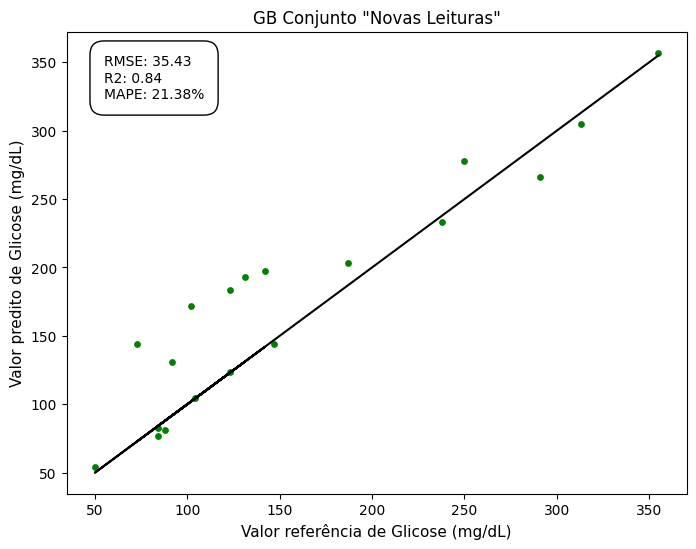

In [10]:
X = data.drop('mg/dL', axis=1)
y = data['mg/dL']

#X_test_scaled = scaler.transform(X)

y_pred = model.predict(X)

# Calcular as métricas de erro
rmse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print('RMSE', rmse)
print('R²', r2)
print('MAPE', mape)
print('MAE', mae)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # Define uma figura com largura 8 e altura 6
# Criar os pontos x para a linha reta
x_line = y

# Criar os pontos y para a linha reta
y_line = y

plt.plot(x_line, y_line, color='black', label='Linha Reta')
plt.scatter(y, y_pred, color='green', label='Pontos Preditos', s=15)

# Configurar os rótulos dos eixos
plt.xlabel('Valor referência de Glicose (mg/dL)', fontsize=11)
plt.ylabel('Valor predito de Glicose (mg/dL)', fontsize=11)

# Configurar o título do gráfico
plt.title('GB Conjunto "Novas Leituras"')

# Adicionar os valores de RMSE, R2, MAPE e MAE no canto superior esquerdo
rmse_text = f'RMSE: {rmse:.2f}'
r2_text = f'R2: {r2:.2f}'
mape_text = f'MAPE: {mape:.2f}%'
mae_text = f'MAE: {mae:.2f}'
plt.text(0.06, 0.95, f'{rmse_text}\n{r2_text}\n{mape_text}', transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.savefig('GB NOVAS LEITURAS.png')
# Exibir o gráfico
plt.show()


<Figure size 640x480 with 0 Axes>

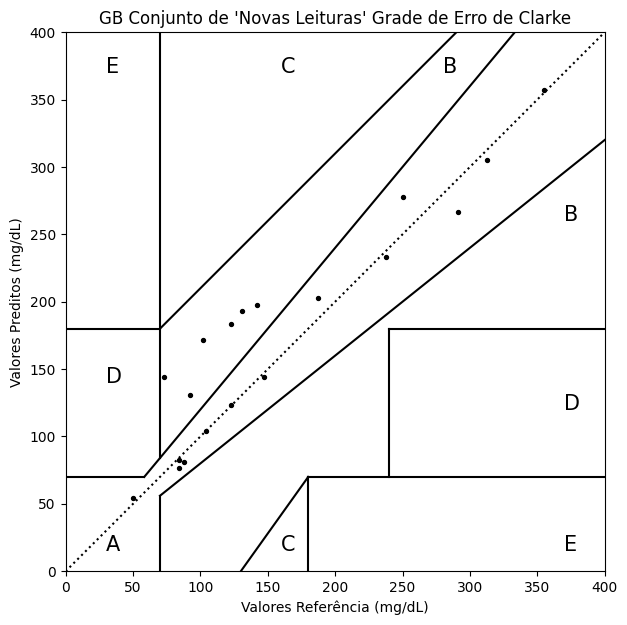

Pontos na Zona A: 13
Pontos na Zona B: 6
Pontos na Zona C: 0
Pontos na Zona D: 0
Pontos na Zona E: 0


In [11]:
# Dados de exemplo: valores de referência e medições do dispositivo
ref_values = data['mg/dL'].values
pred_values = y_pred

title_string = "GB Conjunto de 'Novas Leituras' Grade de Erro de Clarke"

# Chamando a função clarke_error_grid
plot, zone = clarke_error_grid(data['mg/dL'].values, y_pred, title_string)

# Definindo o tamanho da figura


plt.savefig("GB Clarke NOVAS LEITURAS")
# Exibindo o gráfico
plot.show()

print("Pontos na Zona A:", zone[0])
print("Pontos na Zona B:", zone[1])
print("Pontos na Zona C:", zone[2])
print("Pontos na Zona D:", zone[3])
print("Pontos na Zona E:", zone[4])